# Exercise 7
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-02-12: v.1.0. First public release. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

from scipy.optimize import least_squares

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

# 4. Fitting Circles

(2431, 2)


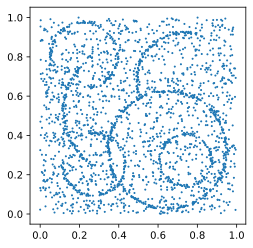

In [2]:
# Import the data
data = np.load("circles.npy")
print(data.shape)

# Visualize in scatter plot
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

As a human, I could probably fit 6-7 circles by visual identification from this scatter plot.

## 4.1 RANSAC (6 pts)
Fitting a circle from three points in 2D, using the method found [here](https://math.stackexchange.com/a/1460096). 

<span style="color: green; font-weight: bold">The sample solution's method of fitting a circle to three points are more minimalistic and most likely more efficient than this method. Anyhow, our solution works and I think it looked fancy, so it was more a curiosity trying it this way instead of the straight-forward way of the sample solution.</span>

In [3]:
def fit_circle(X):
    """
    Fit a circle from 3 points in 2D.
    
    Parameters:
    -----------
    X: np.array shape=(3,2)
        Array containing the points.
    
    Returns:
    --------
    model: np.array shape=(3,)
        Circle parameters. X and Y position of circle
        center, and radius of the circle.
    """
    # Need to check that the three points do not 
    # lie on a straight line.
    if np.abs(np.cross(X[1]-X[0], X[2]-X[0])) < 1e-4:
        return False
        
    # Form matrix A
    Xnorm = np.sum(X**2,axis=1)[:,None]
    ones  = np.ones(3)[:,None]
    A     = np.concatenate((Xnorm, X, ones), axis=1)
    
    # Matrix minors
    A1 = np.linalg.det(np.delete(A, 0, 1))
    A2 = np.linalg.det(np.delete(A, 1, 1))
    A3 = np.linalg.det(np.delete(A, 2, 1))
    A4 = np.linalg.det(np.delete(A, 3, 1))
    
    # Calc circle center and radius
    cx = 0.5*A2/A1
    cy = -0.5*A3/A1
    r  = np.sqrt(cx**2 + cy**2 + A4/A1)
    
    return np.array([cx,cy,r])

In [4]:
def dist_circle(X, model):
    """
    Calculate distances from data set to fitted circle.
    """
    return np.abs(np.sqrt((X[:,0]-model[0])**2+(X[:,1]-model[1])**2)-model[2])

<span style="color: green; font-weight: bold">Our RANSAC implementation is pretty much the same as the one in the sample solution. Slightly different methods and wrapper functions, but in essence the same.</span>

In [5]:
def RANSAC(X, D, T, eps, fit_model, dist_func):
    """
    General purpose RANSAC-algorithm.
    
    Parameters:
    -----------
    X: np.array 
        Feature matrix, each row corresponding to a data instance. 
    D: int
        No. of data points required to fit the chosen model.
    T: int
        No. of RANSAC iterations.
    eps: float
        Threshold for inlier determination.
    fit_model: function
        Function to fit a certain model. Shall take one array
        of D data points, and output the model. If no fit 
        could be found, return False.
    dist_func:
        Function to determine distance from model to all data
        points. Shall input the matrix X, the model and return
        an array of real, positive distances.
    
    Returns:
    --------
    best_model: np.array
        Array containing the parameters of the best fitted model.
    inliers: np.array
        Boolean mask corresponding to X, where True elements are
        considered inliers to best_model.
    """
    max_inliers = 0
    for i in range(T):
        # Pick a random subset of D points.
        X_subset = X[np.random.choice(len(X), size=D, replace=False)]
        
        # Fit the model to the subset.
        model = fit_model(X_subset)
        
        # If a valid model was found:
        if np.any(model):
            # Find distances from all data points to the model.
            distances = dist_func(X, model)
            
            # Count the inliers of the model.
            inlier_current = distances < eps
            inlier_count   = inlier_current.sum()
            
            # If current model has more inliers than the previous 
            # record, save the model.
            if inlier_count > max_inliers:
                max_inliers = inlier_count
                inliers     = inlier_current
                best_model  = model 
                
    return best_model, inliers

<span style="color: green; font-weight: bold">The sample solution never motivated the number of RANSAC iterations used, even though it was explicitly stated in the exercise.</span>

In [6]:
# Estimate the minimum number of RANSAC iterations required.
alpha = 0.99  # Probability of RANSAC success. 
gamma = 0.05  # Inlier fraction.
D     = 3     # No. of data points required to fit chosen model.
T     = np.round(np.log(1-alpha)/np.log(1-gamma**D)).astype('int')
print(f"Estimated minimum no. of RANSAC iterations: {T}")

Estimated minimum no. of RANSAC iterations: 36839


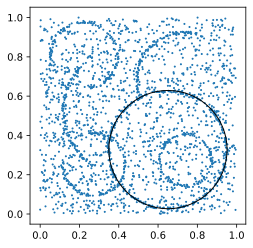

In [7]:
# Parameters
eps = 0.01   # Inlier threshold

# Fit a single circle
model, inliers = RANSAC(data, D, T, eps, fit_circle, dist_circle)

# Visualize underlying data in scatter plot
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

# Plot fitted circle.
circ = plt.Circle((model[0],model[1]), radius=model[2], fill=False)
plt.gca().add_patch(circ)

plt.show()

### Fit multiple circles, by subsequentially removing sets of fitted inliers.

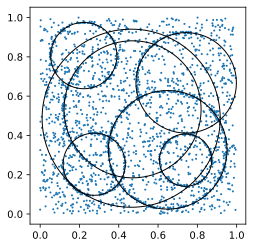

In [8]:
# Parameters
eps       = 0.01    # Inlier threshold
N_circles = 7       # No. circles to fit

# Relabel the dataset.
X = data

# Visualize underlying data in scatter plot.
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

X_list  = []
circles = []
# For each circle
for i in range(N_circles):
    # Find best fit. 
    model, inliers = RANSAC(X, D, 10*T, eps, fit_circle, dist_circle)
    
    # Plot the fitted circle in the diagram.
    circ = plt.Circle((model[0],model[1]), radius=model[2], fill=False)
    plt.gca().add_patch(circ)

    # Save set of inliers and the fitted model
    X_list.append(X[inliers].copy())
    circles.append(model.copy())

    # Remove current model's inliers from the dataset.     
    X = X[~inliers].copy()

plt.show()

It seems to be rather hard to correctly fit the circles, without also incorrectly fitting a circle where there should be none. Here, we correctly fit 6 of the smaller circles, but the largest one looks like a mistake (at least to my eye), where a circle seemingly gets fitted to the background noise after all points associated with the distinct circles are removed from the set. That's why it is also the largest circle, since by being larger in size, it can include more points from the random noise in the domain.  

We also experienced a high sensitivity on the parameter $\epsilon$, and found by trial-and-error an optimum at $\epsilon \approx 0.01$. For values smaller than this, not all points associated with a single circle would be identified and subsequently removed, and thus the algorithm could fit multiple circles to the "same" circle. And for larger values of $\epsilon$, the fitting criterion would be too generous, and a fit could be found almost anywhere in the domain where clustering was large enough. 

<span style="color: green; font-weight: bold">The sample solution's plot is much clearer than our one, for the sole reason that it uses a different marker color for the points used in the circle fits. We definitely should have though of that ourselves, it makes it way more informative on how the fit is actually done. We probably should have increased the figure size as well.</span>

## 4.2 Algebraic Distance (4 pts)

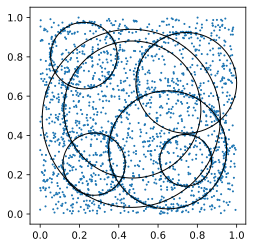

In [9]:
# Visualize underlying data in scatter plot.
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

# For each set of inliers associated with a circle from RANSAC
for X in X_list:
    # Transform of X and Y
    Xt = np.concatenate((X,np.ones(len(X))[:,None]), axis=1)
    Yt = np.sum(X**2, axis=1)
    
    # Solve OLS problem
    beta = np.linalg.solve((Xt.T @ Xt), Xt.T @ Yt)
    
    # Transform back to get circle parameters
    cx = 0.5*beta[0]
    cy = 0.5*beta[1]
    r  = np.sqrt(beta[2] + cx**2 + cy**2)
    
    # Plot the fitted circle in the diagram.
    circ = plt.Circle((cx, cy), radius=r, fill=False)
    plt.gca().add_patch(circ)

plt.show()

The fitting results here are not very different compared to the results obtained above. I'm not sure if that's due to the similarity of the two methods, or that this "improvment" here is ultimately limited by the quality of the subsets obtained from the RANSAC method, or both. Either way, I cannot see any notable improvement here compared to the previous method, the fits are already quite good. 

<span style="color: green; font-weight: bold">The sample solution quite neatly combines 4.2 and 4.3 into the same code, with just a switch statement for the two different loss functions and solving using scipy's `least_squares`. Really nice done. </span>

## 4.3 Levenberg-Marquardt (6 pts)

The optimization objective is 
    \begin{equation}
        \hat{c}, \hat{r} = \min _{c, r} \sum_{i}\left(\left\|x_{i}-c\right\|_{2}-r\right)^{2},
    \end{equation}
    implying a loss function of
    \begin{equation}
        \mathcal{L}(c,r) = \sum_{i}\left(\left\|x_{i}-c\right\|_{2}-r\right)^{2}.
    \end{equation}
    Taking the derivative of the loss with respect to the radius $r$ and solving for the zero, gives
    \begin{align}
        \frac{\partial \mathcal{L}}{\partial r} &= -2\sum_{i}\left(\left\|x_{i}-c\right\|_{2}-r\right) = 0\\
        \Longrightarrow \quad r &= \langle r_i \rangle = \frac{1}{N} \sum_{i}r_i = \frac{1}{N} \sum_{i}\left\|x_{i}-c\right\|_{2},
    \end{align}
    where we defined the radius $r_i$ as
    \begin{equation}
        r_i = \left\|x_{i}-c\right\|_{2}.
    \end{equation}
    Plugging these expressions back into the loss function, we can simplify the function as per
    \begin{align}
        \mathcal{L}(c) &= \sum_{i}\left(r_i - \langle r_i \rangle \right)^{2}\\
        &= \sum_{i} \left(r_i^2 - 2r_i\langle r_i \rangle + \langle r_i \rangle^2 \right)\\
        &= \sum_{i}r_i^2 - 2N \langle r_i \rangle\langle r_i \rangle + N\langle r_i \rangle^2\\
        &= \sum_{i}r_i^2 - N\langle r_i \rangle^2\\
        &= \sum_{i}\left(x^2+ y^2 + c_1^2 + c_2^2 - 2x c_1 - 2y c_2  \right) -  N\langle r_i \rangle^2\\
        &= \sum_{i}\left(x^2+ y^2 \right) + N\left(c_1^2 + c_2^2 - \langle r_i \rangle^2\right) - 2N\langle x\rangle c_1 - 2N\langle y\rangle c_2.
    \end{align}
    Since $x,y$ is independent on the optimization objective, we can drop the term with the sum. Similarly, dividing the expression by the constant $N$ to not alter the objective, and as such we obtain
    \begin{equation}
        \mathcal{L}(c) = c_1^2 + c_2^2 - \langle r_i \rangle^2 - 2\langle x\rangle c_1 - 2\langle y\rangle c_2. 
    \end{equation}
    If we further assume that we center the data before the fit, we will have that the mean position of $x$ and $y$ are zero, i.e. $\langle x\rangle = \langle y\rangle = 0$, which yields
    \begin{equation}
        \mathcal{L}(c) = c_1^2 + c_2^2 - \langle r_i \rangle^2.
    \end{equation}
To employ the Levenberg-Marquardt algorithm, we need the Jacobian of of the loss function, i.e.
    \begin{equation}
        \frac{\partial \mathcal{L}}{\partial c} = \left[\begin{array}{c} \frac{\partial \mathcal{L}}{\partial c_1} \\ \frac{\partial \mathcal{L}}{\partial c_2} \end{array}\right] = \left[\begin{array}{c}  2c_1 - 2\langle r_i \rangle \frac{\partial \langle r_i \rangle}{\partial c_1}  \\2c_2 - 2\langle r_i \rangle \frac{\partial \langle r_i \rangle}{\partial c_2}  \end{array}\right], 
    \end{equation}
    where 
    \begin{align}
        \frac{\partial \langle r_i \rangle}{\partial c_1} &= \frac{1}{N} \sum_{i}\frac{c_1 - x}{\left\|x_{i}-c\right\|_{2}}, \\
        \frac{\partial \langle r_i \rangle}{\partial c_2} &= \frac{1}{N} \sum_{i}\frac{c_2 - y}{\left\|x_{i}-c\right\|_{2}}.
    \end{align}
Then, since we want to minimize the loss function $\mathcal{L}$, the Levenberg-Marquardt algorithm then uses a first order Taylor expansion of the loss at a given current guess $c^{(t-1)}$ of the parameters with an improvement $c^{(t)} = c^{(t-1)} + \Delta$, as per
\begin{equation}
    \mathcal{L}(c^{(t-1)} + \Delta) \approx  \mathcal{L}(c^{(t-1)}) + \frac{\partial \mathcal{L}}{\partial c}\biggr\rvert_{c^{(t-1)}} \cdot \Delta
\end{equation}
This formulation can then be interpreted as a ordinary least-squared minimization problem with respect to the improvement $\Delta$, i.e. 
    \begin{equation}
        \hat{\Delta} = \text{arg min}_{\Delta} \left( \tilde{Y} - \tilde{X}\cdot \Delta \right)^2 + \tau \left\|\Delta \right\|^{2}
    \end{equation}
    where we use regularization $\tau$ to avoid over-fitting, and where we defined
    \begin{align}
        \tilde{Y} &= \mathcal{L}(c^{(t-1)})\\
        \tilde{X} &= \frac{\partial \mathcal{L}}{\partial c}\biggr\rvert_{c^{(t-1)}}. 
    \end{align}
    Then, by sequentially solving these linear problems to gradually improve the fit $c$ through 
    \begin{align}
        \hat{\Delta} &= \left(\tilde{X}^T\tilde{X} + \tau \mathbb{1}\right)^{-1}\tilde{X}^T\tilde{Y}\\
        c^{(t)} &= c^{(t-1)} + \Delta
    \end{align}
    we will after enough iterations arrive at a minimum for a best fit.
    
Here, we instead use scipy's optimization library in `scipy.optimize.least_squares` for our implementation.

<span style="color: green; font-weight: bold">I was quite confused by this question since I could not understand what was asked for. When the question says "Derive the theoretical approach by hand" does that not also imply you should show it? The sample solution did not care at all about this and instead jumped straight into coding. I understand we shouldn't have implemented the full algorithm ourselves since it would have been too much work for the given task, but now we have effectivley not used the Levenberg-Marquardt algorithm at all, right? Since we just gave a wrapped optimization library a loss function without knowing what method is actually used under the hood? </span>

In [10]:
def loss_func(beta, X):
    return np.mean((np.linalg.norm(X-beta[:2], axis=1) - beta[2])**2) 

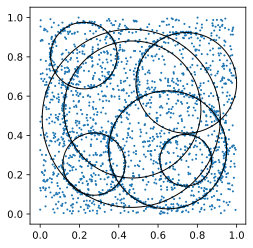

In [11]:
# Visualize underlying data in scatter plot.
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

for i,X in enumerate(X_list):
    # Select dataset
    X = X_list[i]
    
    # Choose inital guess from preciously obtained parameters.
    x0 = circles[i]
    
    # Optimize the fit
    res = least_squares(loss_func, x0, loss='soft_l1', args=(X,))
    
    # Extract results
    cx,cy,r = res.x
    
    # Plot the fitted circle in the diagram.
    circ = plt.Circle((cx, cy), radius=r, fill=False)
    plt.gca().add_patch(circ)
    
plt.show()

Similarly to before, we do not see a noteably improvement of the fit. We know however from theory that this method should be much more robust than the method of minimizing the algebraic distance from above.

## 4.4 Comparison (4 pts)
To compare the two method's reliability towards outliers in the dataset, we create a custom dataset from the first fitted circle and add a few points from another circle set, and compare how well the two methods do in fitting a circle to the data.

(392, 2)
(48, 2)
(440, 2)
Inlier fraction: 0.891


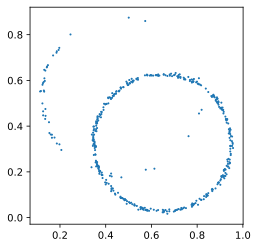

In [12]:
# Base inlier set
X_in = X_list[0]
print(X_in.shape)

# Select few outliers from a different set
X_out = X_list[1][::4]
print(X_out.shape)

# Combine into one data set
X = np.concatenate((X_in,X_out))
print(X.shape)
print(f'Inlier fraction: {np.round(len(X_in)/len(X),3)}')

# Visualize underlying data in scatter plot.
plt.scatter(X[:,0],X[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

### Algebraic distance

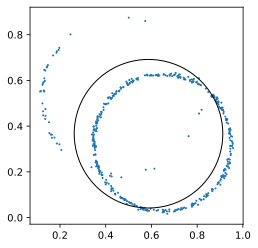

In [13]:
# Visualize underlying data in scatter plot.
plt.scatter(X[:,0],X[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

# Transform of X and Y
Xt = np.concatenate((X,np.ones(len(X))[:,None]), axis=1)
Yt = np.sum(X**2, axis=1)

# Solve OLS problem
beta = np.linalg.solve((Xt.T @ Xt), Xt.T @ Yt)

# Transform back to get circle parameters
cx = 0.5*beta[0]
cy = 0.5*beta[1]
r  = np.sqrt(beta[2] + cx**2 + cy**2)

# Plot the fitted circle in the diagram.
circ = plt.Circle((cx, cy), radius=r, fill=False)
plt.gca().add_patch(circ)

plt.show()

### Levenberg-Marquardt

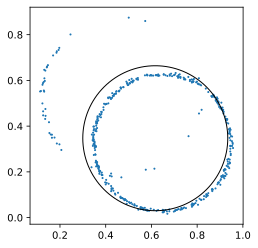

In [14]:
# Visualize underlying data in scatter plot.
plt.scatter(X[:,0],X[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

# Choose inital guess
x0 = np.array([0.5,0.5,0.5])

# Optimize the fit
res = least_squares(loss_func, x0, loss='soft_l1', args=(X,))

# Extract results
cx,cy,r = res.x

# Plot the fitted circle in the diagram.
circ = plt.Circle((cx, cy), radius=r, fill=False)
plt.gca().add_patch(circ)
    
plt.show()

Here we can see that the last algorithm, which optimizes the Euclidean distance, instead of the Algebraic distance, is more stable against outliers in the data. Even though the datasets are the same in this comparison, and thus the number of outliers remain constant, we have a fit that is less affected by the outliers in the last example. Thus, it is preferrable to minimize using the euclidean distance in this case.

<span style="color: green; font-weight: bold">The sample solution's approach to the comparison is probably smarter than this one, since a clearer difference between the methods are showcased. We probably should have included fewer but larger outliers, which would have made the results more clear.</span>